<a href="https://colab.research.google.com/github/NatSy77/projet_7/blob/main/P7_feature_importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implémentez un modèle de scoring #feature importance

## Importation

In [1]:
import joblib
import pandas as pd
import shap
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from joblib import load

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##  Chargement des données

In [4]:
#importation fichier
app_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DS_projet_7/data_modelisation/app_train.csv')
print('Training data shape: ', app_train.shape)

Training data shape:  (307511, 242)


In [5]:
# Testing data features
app_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DS_projet_7/data_modelisation/app_test.csv')

In [6]:
# Chemin vers le pipeline
pipeline_path = '/content/drive/MyDrive/Colab Notebooks/DS_projet_7/mlflow/706359919036996243/6384c7a1e96c4d7088902ac022cd934c/artifacts/LightGBM_pipeline.pkl'
print("Pipeline chargé avec succès.")
model = joblib.load(pipeline_path)  # Le fichier contient directement le modèle LightGBM
print("Modèle LightGBM chargé avec succès.")

Pipeline chargé avec succès.
Modèle LightGBM chargé avec succès.


## Chargement du modele

In [7]:
# Étape 1 : Charger le modele
model = joblib.load(pipeline_path)  # Le fichier contient directement le modèle LightGBM
print("Modèle LightGBM chargé avec succès.")

Modèle LightGBM chargé avec succès.


## Préparation des données (comme pour la modelisation)

In [8]:
# Chargement des données
if 'TARGET' in app_train.columns:
    train = app_train.drop(columns=['TARGET'])
    target = app_train['TARGET']
else:
    train = app_train.copy()
    target = None

# Vérification des valeurs manquantes
if train.isnull().sum().sum() > 0:
    imputer = SimpleImputer(strategy='median')
    train = imputer.fit_transform(train)
else:
    train = train.values  # Conversion explicite si c'est un DataFrame

# Mise à l'échelle des caractéristiques
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)

# Diviser les données en ensembles d'entraînement et de test (si `target` est défini)
if target is not None:
    X_train, X_test, y_train, y_test = train_test_split(
        train, target, test_size=0.2, random_state=42
    )
else:
    X_train, X_test, y_train, y_test = None, None, None, None
    print("Attention : Aucune étiquette ('target') n'a été fournie.")

# Appliquer les mêmes transformations sur les données de test
# (Utilisez les mêmes imputer et scaler, ajustés sur `train`)
app_test = app_test.drop(columns=['TARGET'], errors='ignore')  # Enlever la colonne TARGET si elle existe
app_test = imputer.transform(app_test)
app_test = scaler.transform(app_test)

## Feature Importance Globale

In [9]:
# Vérifier si la colonne TARGET (ou autre colonne de sortie) est présente
target_column = 'TARGET'
if target_column in app_train.columns:
    print(f"La colonne '{target_column}' a été détectée et sera exclue des features.")
    feature_names_transformed = app_train.drop(columns=[target_column]).columns.tolist()
else:
    feature_names_transformed = app_train.columns.tolist()

# Obtenir les importances des caractéristiques à partir du modèle
feature_importances = model.feature_importances_  # Cette ligne est ajoutée pour définir feature_importances

# Vérifier si les longueurs correspondent après exclusion
if len(feature_names_transformed) != len(feature_importances):
    print(f"Longueur des noms de colonnes après exclusion de TARGET : {len(feature_names_transformed)}")
    print(f"Longueur des importances : {len(feature_importances)}")

La colonne 'TARGET' a été détectée et sera exclue des features.


In [10]:
# Créer un dataframe pour visualiser les résultats
importance_df = pd.DataFrame({
    'Feature': feature_names_transformed,
    'Importance': feature_importances
})

# Trier par importance décroissante
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Afficher les 10 caractéristiques les plus importantes
print(importance_df.head(20))

# Sauvegarder dans un fichier CSV
# Chemin de sauvegarde dans Google Drive
output_path = '/content/drive/MyDrive/Colab Notebooks/DS_projet_7/global_feature_importance.csv'

# Sauvegarder le dataframe dans le chemin spécifié
importance_df.to_csv(output_path, index=False)

print(f"Importances globales sauvegardées dans : {output_path}")

                        Feature  Importance
32                 EXT_SOURCE_1         212
34                 EXT_SOURCE_3         194
7                    AMT_CREDIT         166
11                   DAYS_BIRTH         155
33                 EXT_SOURCE_2         152
8                   AMT_ANNUITY         146
12                DAYS_EMPLOYED         131
9               AMT_GOODS_PRICE         128
14              DAYS_ID_PUBLISH         114
82       DAYS_LAST_PHONE_CHANGE          92
6              AMT_INCOME_TOTAL          79
13            DAYS_REGISTRATION          79
0                    Unnamed: 0          52
10   REGION_POPULATION_RELATIVE          51
15                  OWN_CAR_AGE          46
108  AMT_REQ_CREDIT_BUREAU_YEAR          33
2            NAME_CONTRACT_TYPE          33
3                  FLAG_OWN_CAR          30
25      HOUR_APPR_PROCESS_START          30
109               CODE_GENDER_F          29
Importances globales sauvegardées dans : /content/drive/MyDrive/Colab Notebo

## Importances Locales (SHAP)

Calcul des importances locales (SHAP)...


/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


Visualisation des importances locales avec SHAP...


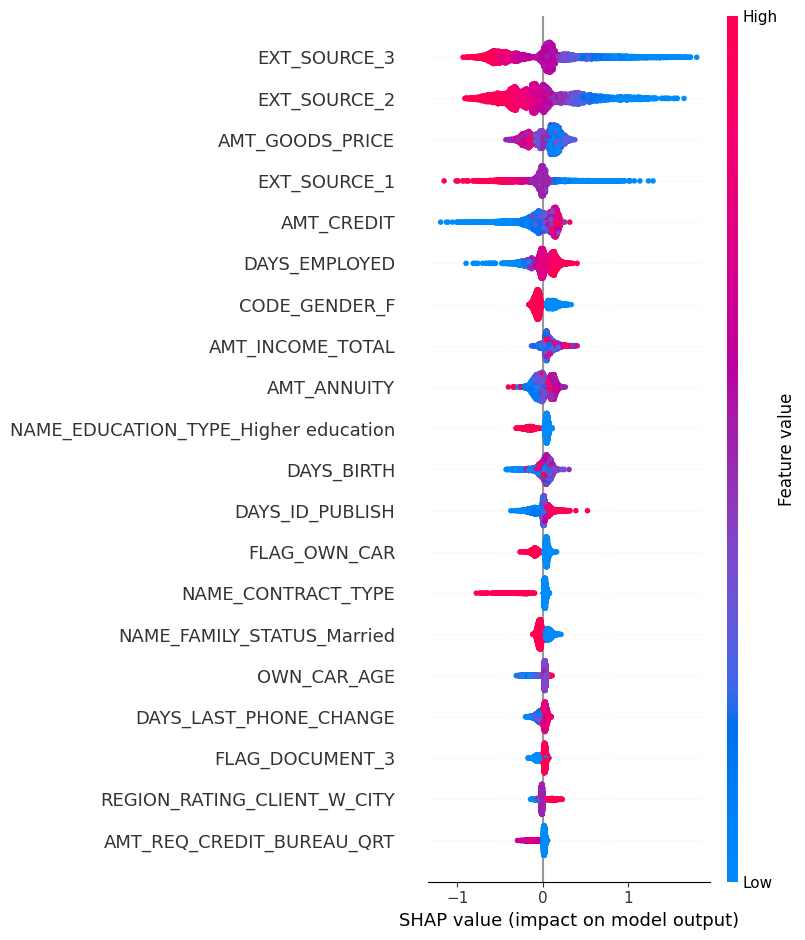

In [11]:
#Calcul des Importances Locales (SHAP)
print("Calcul des importances locales (SHAP)...")
# Réduire la taille de l'échantillon pour SHAP (10%)
X_sampled, _, y_sampled, _ = train_test_split(X_test, y_test, test_size=0.9, random_state=42)

# Créer un explainer SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sampled)

# Visualisation des importances locales
print("Visualisation des importances locales avec SHAP...")
shap.summary_plot(shap_values, X_sampled, feature_names=feature_names_transformed)